<a href="https://colab.research.google.com/github/kropotin4/Notebooks/blob/master/exChal_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow -q

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# Данные

In [5]:
#@title ## Параметры

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/" #@param {type:"string"}

CHAL_NAME = "challenge2" #@param {type:"string"}

In [6]:
dtype = np.double

chal_prefix = CHAL_NAME + "/" + CHAL_NAME
# pd.read_excel | xlsx
# pd.read_csv   | csv
train_features = pd.read_excel(DATA_PATH + chal_prefix + "_x_train.xlsx", header=None, dtype=dtype)
train_labels   = pd.read_excel(DATA_PATH + chal_prefix + "_y_train.xlsx", header=None, dtype=dtype)
test_features  = pd.read_excel(DATA_PATH + chal_prefix + "_x_test.xlsx", header=None, dtype=dtype)

In [7]:
from sklearn.preprocessing import OneHotEncoder

train_labels_oh = OneHotEncoder().fit_transform(train_labels)

train_labels = train_labels_oh.toarray()

In [8]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

## Автокорреляция

In [9]:
corr_kf = 0.85
corr_enable = True

In [10]:
corr = train_features.corr()
col_del = np.zeros(len(corr.columns), dtype=bool)

n_del = 0
for i in range(0, len(corr.columns)):
    if col_del[i] == True:
        continue

    for g in range(i + 1, len(corr.columns)):
        if abs(corr[i][g]) > corr_kf:
            col_del[g] = True
            n_del += 1

col_del_ind = [i for i in range(0, len(col_del)) if col_del[i]]

print("Del features: " + str(n_del))

Del features: 9


In [11]:
if corr_enable:
    train_features.drop(train_features.columns[col_del_ind],axis=1,inplace=True)
    test_features.drop(test_features.columns[col_del_ind],axis=1,inplace=True)

## Линейная регрессия

In [12]:
lin_weight_min = 0.1
lin_enable = 0

In [13]:
from sklearn import linear_model
from sklearn.metrics import r2_score

if lin_enable:
    lasso = linear_model.Lasso(alpha=1)
    el_net = linear_model.ElasticNet(alpha=1)

    lin_mod = lasso # el_net lasso

    lin_fit = lin_mod.fit(train_features, train_labels)

    print(r2_score(train_labels, lin_fit.predict(train_features)))

In [14]:
if lin_enable:
    lin_weight_ind = [i for i in range(0, len(train_features.columns)) \
                        if abs(lin_fit.coef_[i]) < lin_weight_min]

    print(lin_weight_ind)

## Нормализация

In [15]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler().fit(train_features)

train_features = std_data.transform(train_features)
test_features = std_data.transform(test_features)

## Количество признаков/классов

In [16]:
n_features = train_features.shape[1]
n_class = train_labels.shape[1]

print("Number of objects: " + str(train_features.shape[0]))
print("Number of features: " + str(n_features))
print("Number of class: " + str(n_class))

Number of objects: 2416
Number of features: 20
Number of class: 13


# Модель

## Функции

In [ ]:
def to_onehot(data):
    oh = [data[i].argmax() for i in range(0, len(data))]
    oh = np.array(oh).reshape(-1, 1)
    oh = OneHotEncoder().fit_transform(oh)
    return oh

In [17]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [18]:
from tqdm.keras import TqdmCallback
from IPython.display import clear_output

def fit_nn(model, 
           n_rounds: int,
           target=None, 
           verbose=True):
    success = 0
    wb_list = []

    for t in range(n_rounds):
        if not verbose:
            print(str(t) + "/" + str(n_rounds))
            
        try:
            reset_weights(model)

            model.fit(train_features, train_labels, \
                        epochs=500, validation_split=0.1, batch_size=32, \
                        verbose=0, callbacks=[TqdmCallback(verbose=0)])
            
        except Exception as e:
            if verbose:
                print(str(t) + ": fail; " + str(e))
        else:
            success += 1
            r2 = r2_score(train_labels, model.predict(train_features))
            wb_list.append({'score': r2, 'wb': model.get_weights()})
            if verbose:
                print(str(t) + ": success (" + str(r2) + ")")
            if (target != None):
                if (r2 >= target):
                    break

        finally:
            if not verbose:
                clear_output(wait=True)
    
    print("Succes ratio: " + str(success / n_rounds))
    return wb_list

## Немного эвристики

In [19]:
alfa = 2
Nh = len(train_features) / (alfa * (n_features + n_class))
print("Layers number: " + str(Nh))

Layers number: 36.60606060606061


In [20]:
import math
m = n_class
n_object = len(train_features)
hid_nodes1 = math.sqrt((m + 2)*n_object) + 2*math.sqrt(n_object / (m + 2))
hid_nodes2 = m*math.sqrt(n_object / (m + 2))

print("First layer:" + str(math.ceil(hid_nodes1)))
print("Second layer:" + str(math.ceil(hid_nodes2)))

First layer:216
Second layer:165


## Модель

In [79]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = keras.Sequential(name="Best")

lrelu = lambda x: keras.activations.relu(x, alpha=0.01)
relu = keras.activations.relu
sig = keras.activations.sigmoid
swish = keras.activations.swish

activ_func = lrelu

model.add(tf.keras.Input(shape=(n_features,)))

model.add(Dense(units=n_features, activation=activ_func, name="Input"))

model.add(Dense(units=220, activation=activ_func, name="Hidden1"))
#model.add(BatchNormalization())
model.add(Dense(units=180, activation=activ_func, name="Hidden2"))
#model.add(BatchNormalization())
#model.add(Dense(units=32, activation=activ_func, name="Hidden3"))
#model.add(BatchNormalization())
#model.add(Dense(units=32, activation=activ_func, name="Hidden4"))
#model.add(BatchNormalization())
#model.add(Dense(units=32, activation=activ_func, name="Hidden5"))
#model.add(BatchNormalization())
#model.add(Dense(units=32, activation=activ_func, name="Hidden6"))
#model.add(BatchNormalization())
model.add(Dense(units=n_class, activation='softmax', name="Output"))

adam = keras.optimizers.Adam(learning_rate=0.001)
nadam = keras.optimizers.Nadam(learning_rate=0.001)
adadelta = keras.optimizers.Adadelta(learning_rate=0.001)
adagrad = keras.optimizers.Adagrad(learning_rate=0.1)
rms = keras.optimizers.RMSprop(learning_rate=0.0001)
sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True)

# mean_absolute_error
# mean_squared_error
# mean_squared_logarithmic_error 
# cosine_similarity
huber = keras.losses.Huber(delta=0.8, reduction="auto", name="huber_loss")
# log_cosh 
# categorical_crossentropy
# sparse_categorical_crossentropy

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')

In [22]:
#print(model.summary())

In [80]:
from tqdm.keras import TqdmCallback

log = model.fit(train_features, train_labels, \
                epochs=500, validation_split=0.05, batch_size=32, \
                verbose=0, callbacks=[TqdmCallback(verbose=0)])

In [24]:
#wb_list = fit_nn(model=model, n_rounds=30, verbose=False)

In [25]:
#wb_list.sort(reverse=True, key=lambda d: d['score'])
#wb_plot = [d['score'] for d in wb_list]
#plt.plot(wb_plot)

In [26]:
#model.set_weights(wb_list[0]['wb'])

# Сохранение результата

In [85]:
#test_predict = np.round(model.predict(test_features), -1)

test_predict = model.predict(test_features)
test_predict = [test_predict[i].argmax() for i in range(0, len(test_predict))]
test_predict = pd.Series(test_predict)

In [88]:
pd.Series(test_predict).to_csv(DATA_PATH + "lab2_challenge.csv", header=None, index=False)

# Резльтаты

In [81]:
predict = model.predict(train_features)

predict_oh = [predict[i].argmax() for i in range(0, len(predict))]
predict_oh = np.array(predict_oh).reshape(-1, 1)
predict_oh = OneHotEncoder().fit_transform(predict_oh)

In [82]:
from sklearn.metrics import r2_score, accuracy_score

#print(r2_score(train_labels, predict))
print(accuracy_score(train_labels, predict_oh))

0.9350165562913907


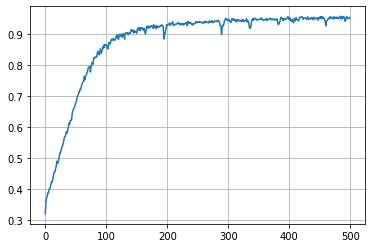

In [83]:
plt.plot(log.history['accuracy'])
plt.grid(True)
plt.show()